In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

plt.rcParams["font.family"] = "Courier New"

SQM_PER_SQMILE = 2_589_988.11

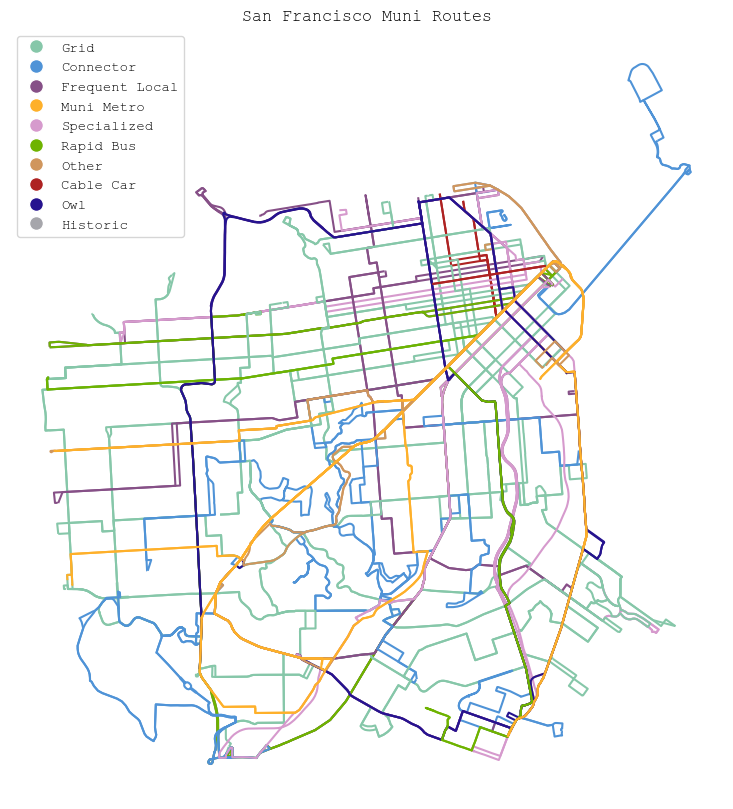

In [2]:
# plot muni routes (for funsies, unrelated to the rest of the analysis)
muni_routes = gpd.read_file(
    "../Data/muni_routes/geo_export_2d59337c-8078-474d-b014-f4d27082661d.shp"
)
cmap = {
    "Grid": "#86c7a9",
    "Connector": "#4F93D7",
    "Frequent Local": "#865087",
    "Muni Metro": "#feb02a",
    "Specialized": "#d69acd",
    "Rapid Bus": "#6EB300",
    "Other": "#D0965D",
    "Cable Car": "#AE2222",
    "Owl": "#26138F",
    "Historic": "#A6A6AB",
}
muni_routes["color"] = muni_routes["service_ca"].map(cmap)

ax = muni_routes.plot(
    color=muni_routes["color"],
    figsize=(10, 10),
    legend=True,
).set_axis_off()
plt.title("San Francisco Muni Routes")

legend_colors = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

In [ ]:
# import data on sf slopes, tree canopy, and plant community areas
sf_slopes = gpd.read_file(
    "../Data/sf_slopes/geo_export_6acd7236-1518-4d7d-9ad6-cfa88e27e519.shp"
)
sf_tree_canopy = gpd.read_file(
    "../Data/sf_urban_tree_canopy/geo_export_9b5977bf-5f79-49ae-9d92-2c665aa1bec3.shp"
)
sf_plant_areas = gpd.read_file(
    "../Data/sf_plant_community_areas/geo_export_93835737-477a-4a88-bf1f-382e3b4d4f2f.shp"
)

In [ ]:
# convert layers to projected CRS
projected_crs = "EPSG:26910"
sf_tree_canopy = sf_tree_canopy.to_crs(projected_crs)
sf_plant_areas = sf_plant_areas.to_crs(projected_crs)
sf_slopes = sf_slopes.to_crs(projected_crs)

In [ ]:
# overlay areas with slope grade > 20% and tree canopy
fig, ax = plt.subplots(figsize=(10, 10))

slope_color = "#FFD15D"
canopy_color = "#1E6608"

sf_slopes.plot(ax=ax, color=slope_color, label="Slopes > 20%")

sf_tree_canopy.plot(ax=ax, color=canopy_color, alpha=0.5, label="Tree Canopy")

ax.set_axis_off()
plt.title("San Francisco Slopes and Tree Canopy")

legend_elements = [
    Patch(facecolor=slope_color, label="Slopes > 20% Grade"),
    Patch(facecolor=canopy_color, label="Tree Canopy"),
]

ax.legend(handles=legend_elements, loc="upper left")

plt.show()

/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_83010/3376562196.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
# calculate total area and pcts (for sanity check)
sf_total_area = 46.87

total_slope_area = sf_slopes.geometry.area.sum() / SQM_PER_SQMILE
total_canopy_area = sf_tree_canopy.geometry.area.sum() / SQM_PER_SQMILE

slope_pct = (total_slope_area / sf_total_area) * 100
canopy_pct = (total_canopy_area / sf_total_area) * 100

print(f"total sf_slopes area: {total_slope_area:.2f} square miles")
print(f"total sf_tree_canopy area: {total_canopy_area:.2f} square miles")

print(f"sf_slopes coverage: {slope_pct:.1f}%")
print(f"sf_tree_canopy coverage: {canopy_pct:.1f}%")

# tree canopy % should be ~13.7 (see ref below)
# https://sfplanning.org/urban-forest-plan#:~:text=Today%2C%20the%20City's%20urban%20tree,unfortunately%2C%20it's%20on%20the%20decline.

total sf_slopes area: 7.61 square miles
total sf_tree_canopy area: 6.48 square miles
sf_slopes coverage: 16.2%
sf_tree_canopy coverage: 13.8%


In [ ]:
# ---------------------- map plant community areas ----------------------

cmap = {
    "Dunes": "#e2cca1",
    "Riparian": "#669FD7",
    "Wetland": "#C394D1",
    "Coastal Scrub": "#feb02a",
    "Woodland": "#66a17c",
    "Grassland/Prairie": "#B5D18A",
}
sf_plant_areas["color"] = sf_plant_areas["habitat"].map(cmap)

ax = sf_plant_areas.plot(
    color=sf_plant_areas["color"],
    figsize=(10, 10),
    alpha=0.6,
    legend=True,
).set_axis_off()
plt.title("San Francisco Plant Community Areas")

legend_colors = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

In [ ]:
# Compute area for each plant zone
sf_plant_areas["zone_area"] = sf_plant_areas.geometry.area
zone_areas = sf_plant_areas.groupby("habitat")["zone_area"].sum().reset_index()

# Compute intersection in projected CRS
canopy_intersection = gpd.overlay(sf_plant_areas, sf_tree_canopy, how="intersection")

# Compute tree canopy area per intersection
canopy_intersection["canopy_area"] = canopy_intersection.geometry.area

# Aggregate total canopy area per habitat
canopy_by_zone = (
    canopy_intersection.groupby("habitat")["canopy_area"].sum().reset_index()
)

# Merge and compute percentage
canopy_zone_stats = canopy_by_zone.merge(zone_areas, on="habitat")
canopy_zone_stats["canopy_pct"] = (
    canopy_zone_stats["canopy_area"] / canopy_zone_stats["zone_area"] * 100
)

In [ ]:
# ---------------------- total area by plant community zone ----------------------
colors = [cmap.get(h, "#cccccc") for h in zone_areas["habitat"]]

zone_areas = zone_areas.sort_values("zone_area", ascending=False)

zone_areas.plot.bar(x="habitat", y="zone_area", color=colors, legend=False)
plt.ylabel("Area (sq miles)")
plt.xlabel("Plant Community Zone")
plt.title("Total Area by Plant Community Zone")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_83010/1090085945.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
# ---------------------- canopy coverage % per plant community zone ----------------------
canopy_zone_stats = canopy_zone_stats.sort_values("canopy_pct", ascending=False)

colors = [cmap.get(h, "#cccccc") for h in canopy_zone_stats["habitat"]]

canopy_zone_stats.plot.bar(x="habitat", y="canopy_pct", color=colors, legend=False)
plt.ylabel("Tree Canopy Coverage (%)")
plt.xlabel("Plant Community Zone")
plt.title("Tree Canopy % Coverage by Plant Community Zone")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

canopy_zone_stats

/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_83010/3962037920.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


,habitat,canopy_area,zone_area,canopy_pct
0,Coastal Scrub,9.393893e+06,5.340366e+07,17.590356
4,Wetland,2.056453e+06,1.239729e+07,16.587927
2,Grassland/Prairie,1.217354e+07,8.441139e+07,14.421680
5,Woodland,2.832613e+06,1.992789e+07,14.214313
1,Dunes,4.620304e+06,3.392966e+07,13.617298
3,Riparian,2.323228e+06,1.917683e+07,12.114770


In [ ]:
# ---------------------- canopy area per plant community zone ----------------------

# convert sq m to miles
canopy_by_zone["canopy_area_miles"] = canopy_by_zone["canopy_area"] / SQM_PER_SQMILE

canopy_by_zone = canopy_by_zone.sort_values("canopy_area_miles", ascending=False)

colors = [cmap.get(h, "#cccccc") for h in canopy_by_zone["habitat"]]

canopy_by_zone.plot.bar(x="habitat", y="canopy_area_miles", color=colors, legend=False)
plt.ylabel("Tree Canopy Area (sq miles)")
plt.xlabel("Plant Community Zone")
plt.title("Tree Canopy Area by Plant Community Zone")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

canopy_by_zone

/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_83010/1693175801.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


,habitat,canopy_area,canopy_area_miles
2,Grassland/Prairie,1.217354e+07,4.700230
0,Coastal Scrub,9.393893e+06,3.627002
1,Dunes,4.620304e+06,1.783909
5,Woodland,2.832613e+06,1.093678
3,Riparian,2.323228e+06,0.897004
4,Wetland,2.056453e+06,0.794001


In [ ]:
# ---------------------- slope coverage % per plant community zone ----------------------

# Compute intersection
slope_intersection = gpd.overlay(sf_plant_areas, sf_slopes, how="intersection")

# Compute slope area per intersection
slope_intersection["slope_area"] = slope_intersection.geometry.area

# Aggregate total slope area per habitat
slope_by_zone = slope_intersection.groupby("habitat")["slope_area"].sum().reset_index()

# Merge and compute percentage
slope_zone_stats = slope_by_zone.merge(zone_areas, on="habitat")
slope_zone_stats["slope_pct"] = (
    slope_zone_stats["slope_area"] / slope_zone_stats["zone_area"] * 100
)

slope_zone_stats = slope_zone_stats.sort_values("slope_pct", ascending=False)

colors = [cmap.get(h, "#cccccc") for h in slope_zone_stats["habitat"]]

slope_zone_stats.plot.bar(x="habitat", y="slope_pct", color=colors, legend=False)
plt.ylabel("Slope Coverage (%)")
plt.xlabel("Plant Community Zone")
plt.title("Slope % Coverage by Plant Community Zone")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

slope_zone_stats

/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_83010/3444328158.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


,habitat,slope_area,zone_area,slope_pct
0,Coastal Scrub,1.273128e+07,5.340366e+07,23.839714
2,Grassland/Prairie,1.578323e+07,8.441139e+07,18.697983
5,Woodland,3.448027e+06,1.992789e+07,17.302517
4,Wetland,1.865259e+06,1.239729e+07,15.045699
3,Riparian,2.755028e+06,1.917683e+07,14.366443
1,Dunes,3.208151e+06,3.392966e+07,9.455298


In [ ]:
# ---------------------- slope area per plant community zone ----------------------

slope_by_zone["slope_area_miles"] = slope_by_zone["slope_area"] / SQM_PER_SQMILE

slope_by_zone = slope_by_zone.sort_values("slope_area_miles", ascending=False)

colors = [cmap.get(h, "#cccccc") for h in slope_by_zone["habitat"]]

slope_by_zone.plot.bar(x="habitat", y="slope_area_miles", color=colors, legend=False)
plt.ylabel("Slope Area (sq miles)")
plt.xlabel("Plant Community Zone")
plt.title("Slope Area by Plant Community Zone")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

slope_by_zone

/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_83010/1624534145.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


,habitat,slope_area,slope_area_miles
2,Grassland/Prairie,1.578323e+07,6.093938
0,Coastal Scrub,1.273128e+07,4.915574
5,Woodland,3.448027e+06,1.331291
1,Dunes,3.208151e+06,1.238674
3,Riparian,2.755028e+06,1.063722
4,Wetland,1.865259e+06,0.720180


In [ ]:
# ---------------------- plot all stats together for better comparison ----------------------
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Colors for bars
canopy_colors = [cmap.get(h, "#cccccc") for h in canopy_zone_stats["habitat"]]
slope_colors = [cmap.get(h, "#cccccc") for h in slope_zone_stats["habitat"]]
canopy_area_colors = [cmap.get(h, "#cccccc") for h in canopy_by_zone["habitat"]]
slope_area_colors = [cmap.get(h, "#cccccc") for h in slope_by_zone["habitat"]]

# 1. Tree Canopy Coverage % by Plant Community Zone
axs[0, 0].bar(
    canopy_zone_stats["habitat"], canopy_zone_stats["canopy_pct"], color=canopy_colors
)
axs[0, 0].set_ylabel("Tree Canopy Coverage (%)")
axs[0, 0].set_title("Tree Canopy % Coverage by Plant Community Zone")
axs[0, 0].tick_params(axis="x", rotation=45)

# 2. Slope Coverage % by Plant Community Zone
axs[0, 1].bar(
    slope_zone_stats["habitat"], slope_zone_stats["slope_pct"], color=slope_colors
)
axs[0, 1].set_ylabel("Slope Coverage (%)")
axs[0, 1].set_title("Slope % Coverage by Plant Community Zone")
axs[0, 1].tick_params(axis="x", rotation=45)

# 3. Tree Canopy Area by Plant Community Zone (sq miles)
axs[1, 0].bar(
    canopy_by_zone["habitat"],
    canopy_by_zone["canopy_area_miles"],
    color=canopy_area_colors,
)
axs[1, 0].set_ylabel("Tree Canopy Area (sq miles)")
axs[1, 0].set_title("Tree Canopy Area by Plant Community Zone")
axs[1, 0].tick_params(axis="x", rotation=45)

# 4. Slope Area by Plant Community Zone (sq miles)
axs[1, 1].bar(
    slope_by_zone["habitat"], slope_by_zone["slope_area_miles"], color=slope_area_colors
)
axs[1, 1].set_ylabel("Slope Area (sq miles)")
axs[1, 1].set_title("Slope Area by Plant Community Zone")
axs[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_83010/373782098.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
